In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from os.path import join, dirname, basename, exists, isdir

### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory


# make folders specific for certain data
folder_name = ''
if folder_name != '':
    #make folders if they don't exist
    if not exists(join(RAW_EXTERNAL, folder_name)):
        os.makedirs(join(RAW_EXTERNAL, folder_name))

    if not exists(join(INTERMEDIATE, folder_name)):
        os.makedirs(join(INTERMEDIATE, folder_name))

    if not exists(join(FINAL, folder_name)):
        os.makedirs(join(FINAL, folder_name))


print('Standard variables loaded, you are good to go!')

Standard variables loaded, you are good to go!


In [2]:
import pandas as pd
import re

# Extract of supplementary table 5:
data = pd.read_csv(f"{RAW_INTERNAL}/proteomics/protein_values.csv", index_col=0)
data_counts = pd.read_csv(f"{RAW_EXTERNAL}/raw_proteomics_all.csv", index_col=0)
data_counts = data_counts.drop(data_counts.index[0])

# remove original index and duplicates
data_counts.index = data_counts['UP']

# # Molecular weights:
MW = data["Molecular weight (Da)"] # Da = g/mol
MW = MW / 1000 # kDa = g/mmol
print(MW)



Uniprot Accession
P0A8T7    155.045008
P0A8V2    150.520276
P36683     93.420946
P15254    141.295898
P09831    163.176315
             ...    
P36667     31.022762
P0AC78     40.912094
P76164      8.702816
P38506     28.130364
Q46810     21.481914
Name: Molecular weight (Da), Length: 2359, dtype: float64


In [3]:
# start and end columns
start_column = data_counts.columns.get_loc("LB")
end_column = data_counts.columns.get_loc("fructose.2")

# rename columns from .2 to uncertainty
# rename_dict = {col_name:re.sub(r".2$", "_uncertainty", col_name) for col_name in \
#  data.columns[start_column_uncertainty:end_column_uncertainty+1]}
# data = data.rename(columns=rename_dict)
# list of indices of data needed
list_of_indices = list(range(start_column,end_column+1))
data_counts = data_counts.iloc[:, list_of_indices]

# get cell volumes
cell_volumes = pd.read_csv(f"{RAW_INTERNAL}/proteomics/growth_conditions.csv", index_col=0)
cell_volumes = cell_volumes["Single cell volume [fl]1"]
# remove the first two rows of LB
cell_volumes = cell_volumes.loc[~cell_volumes.index.duplicated(keep='first')]
# rename the number 3 in there
cell_volumes = cell_volumes.rename({'Osmotic-stress glucose3':'Osmotic-stress glucose_uncertainty'}, axis='index')


In [4]:
# Convert values to mmol/cell:
data_counts = data_counts.apply(lambda x: pd.to_numeric(x, errors='coerce'))
data_counts = data_counts.astype(float) / 6.022e+23 * 1000

# convert names
cell_volumes.index = [re.sub(r'\W+', '', i).lower() for i in cell_volumes.index]
data_counts.columns = [re.sub(r'\W+', '', i).lower() for i in data_counts.columns]


# Iterate through the dataset and divide by the corresponding cell volume, to get mmol/fL:
for (col_name, d) in data_counts.iteritems():
    chemo_name = re.sub(r'2$', '', re.sub(r'1$', '', col_name))
    try:
        data_counts[col_name] = data_counts[col_name] / cell_volumes.loc[chemo_name]#["cell_volume"]
    except:
        print(chemo_name)

# Finally, convert to mmol/gDW:
water_content = 0.3
cell_density = 1.105e-12
data_counts = data_counts / cell_density / water_content



chemostatµ01
chemostatµ01
stationary1day
stationary1day
stationary1day
stationary3days
stationary3days
stationary3days
glucose3
glucose4
glucose5
50mmnacl
50mmnacl
50mmnacl
42c
42c
42c
ph6
ph6
ph6


In [5]:
data_counts.to_csv(f"{INTERMEDIATE}/proteomics/proteomics_concentrations.csv")

In [5]:
data_counts

,lb,lb1,lb2,glucose,glucose1,glucose2,glycerolaa,glycerolaa1,glycerolaa2,acetate,...,mannose2,galactose,galactose1,galactose2,succinate,succinate1,succinate2,fructose,fructose1,fructose2
UP,,,,,,,,,,,,,,,,,,,,,
P0CE47,4.655316e-04,5.628478e-04,5.182709e-04,4.665471e-04,4.420587e-04,4.452832e-04,4.824712e-04,5.023674e-04,4.692813e-04,3.403344e-04,...,3.783274e-04,3.292348e-04,3.179752e-04,3.087803e-04,3.847406e-04,3.803226e-04,3.573912e-04,4.155923e-04,3.848225e-04,3.945081e-04
P0ACF0,3.313111e-04,2.745504e-04,3.253497e-04,2.537021e-04,2.275182e-04,2.344697e-04,2.416969e-04,2.400731e-04,2.209028e-04,1.610615e-04,...,2.339590e-04,2.079737e-04,2.359290e-04,2.067559e-04,2.377118e-04,2.354625e-04,2.177450e-04,2.120681e-04,1.978381e-04,2.008039e-04
P0A853,1.789335e-04,4.389220e-05,5.181937e-05,1.076327e-06,1.087502e-06,1.081659e-06,1.010512e-04,9.043585e-05,1.129075e-04,5.269668e-06,...,3.266923e-06,3.154334e-06,2.865178e-06,3.250558e-06,3.110155e-06,3.524727e-06,3.350238e-06,1.249642e-06,1.184053e-06,1.102541e-06
P0A910,1.710981e-04,1.780586e-04,1.697720e-04,1.954316e-04,2.110953e-04,2.122707e-04,2.077563e-04,2.035243e-04,1.974082e-04,1.653773e-04,...,1.439189e-04,1.495284e-04,1.655104e-04,1.817913e-04,2.014600e-04,1.609613e-04,1.732017e-04,1.533861e-04,1.545967e-04,1.634537e-04
P02359,1.591925e-04,1.658346e-04,1.543944e-04,9.528520e-05,1.014564e-04,9.499480e-05,9.742832e-05,1.031588e-04,1.185479e-04,5.778556e-05,...,6.653517e-05,4.593589e-05,4.181232e-05,4.389708e-05,6.614705e-05,7.621956e-05,5.304523e-05,6.622680e-05,7.893556e-05,7.454952e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P05704,8.217371e-12,8.109989e-12,8.406858e-12,1.789377e-10,3.678485e-10,3.385320e-10,8.102814e-12,1.216312e-11,6.145022e-10,2.510370e-10,...,9.313054e-11,3.200696e-10,1.401462e-10,5.192079e-10,1.197967e-09,2.477798e-10,1.224964e-09,1.269227e-09,1.072460e-09,1.802290e-09
P76398,7.861855e-12,6.664062e-10,7.829699e-12,3.114742e-10,7.766678e-12,7.754010e-12,3.241262e-10,2.099711e-10,7.234693e-09,2.530667e-10,...,6.411270e-11,7.618461e-12,7.546473e-12,7.737157e-12,3.622030e-10,7.484574e-09,1.579693e-09,3.745901e-10,1.079437e-08,8.886849e-09
P21517,7.593437e-12,1.398698e-09,8.736778e-10,1.602923e-09,1.935851e-10,1.980843e-09,7.500869e-12,1.008350e-09,2.223322e-10,1.138845e-09,...,4.427202e-10,8.359083e-10,6.863310e-10,5.258411e-10,1.908785e-10,4.613098e-10,9.620137e-10,2.850491e-10,7.483965e-12,4.967475e-10


[0.50849855 0.09424077]


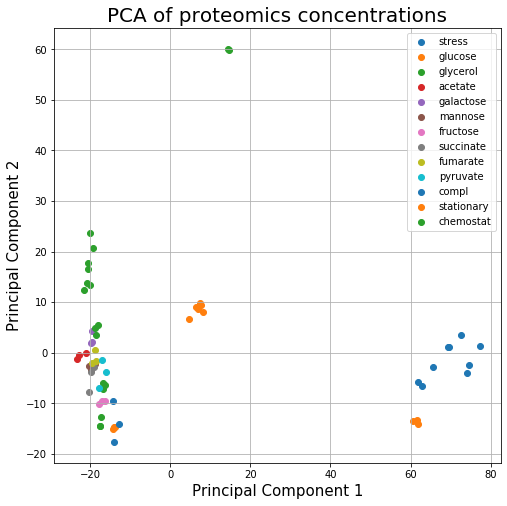

In [15]:
from sklearn.preprocessing import StandardScaler

def is_in(list_a, list_b):
    output_list = []
    for i in list_a:
        for j in list_b:
            if i in j:
                output_list.append(j)
    return output_list

# proteomics data basic analysis
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_df = data_counts.dropna().transpose()
X = StandardScaler().fit_transform(X_df)
pca = PCA(n_components=2)
pca.fit(X)
PCA(n_components=2)
print(pca.explained_variance_ratio_)

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'], index=X_df.index)

stress = is_in(['50mmnacl', '42c', 'ph6'], X_df.index)
minimal = is_in(["glucose", "glycerol", "acetate", "galactose", "mannose", "succinate", "fructose", \
                "fumarate", "pyruvate", "galactose"], X_df.index)
glucose = is_in(["glucose"], X_df.index)
glycerol = is_in(["glycerol"], X_df.index)
acetate = is_in(["acetate"], X_df.index)
galactose = is_in(["glucose"], X_df.index)
mannose = is_in(["mannose"], X_df.index)
fructose = is_in(["fructose"], X_df.index)
succinate = is_in(["succinate"], X_df.index)
fumarate = is_in(["fumarate"], X_df.index)
pyruvate = is_in(["pyruvate"], X_df.index)
galactose = is_in(["galactose"], X_df.index)


compl = is_in(["lb"], X_df.index)
stationary = is_in(["stationary"], X_df.index)
chemostat = is_in(["chemostat"], X_df.index)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
labels =  ["stress", "glucose", "glycerol", "acetate", "galactose", "mannose", "fructose",\
              "succinate", "fumarate", "pyruvate", "compl", "stationary", "chemostat"]
conditions = [stress, glucose, glycerol, acetate, galactose, mannose, fructose,\
              succinate, fumarate, pyruvate, compl, stationary, chemostat]

for i in range(0,len(conditions)):
    try:
        ax.scatter(principalDf.loc[conditions[i], 'principal component 1'], principalDf.loc[conditions[i], 'principal component 2'], label= labels[i])
    except:
        print(i)
        pass
plt.legend()
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA of proteomics concentrations', fontsize = 20)
ax.grid()



plt.savefig(f'{FIGURES}/PCA_conc')

In [47]:
ax.get_legend_handles_labels()

([], [])

In [11]:
glycerol

['glycerolaa',
 'glycerolaa1',
 'glycerolaa2',
 'glycerol',
 'glycerol1',
 'glycerol2']